# AI Powered Payroll

**Problem Understanding** - \
**Goal** - Create anomaly detection engine to detect anomalies in payroll
1. Salary manipulation
2. Fake overtime

**Constraints**
1. No labeled data
2. Must use unsupervised learning
3. Must work for real-time + batch
4. Must handle concept drift

# Complete workflow

The complete workflow in brief that I will follow:

${Problem\ Definition}$ -> $Data\ Collection$ -> $Data\ Understanding$ -> $Data\ Cleaning$ -> $Feature\ Engineering$ -> $Categorical\ Encoding$ -> $Feature\ Selection$ -> $Feature\ Scaling$ -> $Model\ Selection$ -> $Model\ Training$ -> $Anomaly\ Scoring$ -> $Anomaly\ Detection$ -> $Evaluation\ (No\ Labels)$ -> $Concept\ Drift\ Handling$ -> $Batch\ Pipeline\ Design$ -> $Real-Time\ Pipeline\ Design$ -> $Deployment\ Planning$ -> $Documentation\ and\ pesudocode$

1. **Data Collection** - Gather payroll data such as base salary, overtime hours, overtime pay, department, and time information.
3. **Data Understanding** - Analyze data structure, distributions, and identify missing or invalid values.
4. **Data Cleaning** - Handle missing values, remove invalid records, and ensure data consistency.
5. **Feature Engineering** - Create meaningful features such as overtime pay per hour and salary deviation from department averages.
6. **Categorical Encoding** - Convert categorical variables (e.g., department) into numerical representations.
7. **Feature Selection** - Select relevant features that help identify anomalous payroll behavior.
8. **Feature Scaling** - Normalize or standardize features to ensure fair model learning.
9. **Model Selection** - Choose an appropriate unsupervised anomaly detection algorithm (e.g., Isolation Forest).
10. **Model Training** - Train the model on historical payroll data assuming most records are normal.
11. **Anomaly Scoring** - Generate anomaly scores for each payroll record.
12. **Anomaly Detection** - Flag records with high anomaly scores as suspicious.
13. **Evaluation (Without Labels)** - Evaluate model behavior using statistical thresholds, stability checks, and manual review.
14. **Concept Drift Handling** - Monitor data distribution changes and retrain the model periodically.
15. **Batch Pipeline Design** - Run anomaly detection on scheduled payroll batches for audits and compliance.
16. **Real-Time Pipeline Design** - Detect anomalies instantly during live payroll or overtime submissions.
17. **Deployment Planning** - Deploy the model with monitoring, logging, and alert mechanisms.

# Import libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from datetime import datetime

# Step 1 : Data Collection 
**Gather payroll data such as base salary, overtime hours, overtime pay, department, and time information.**

The model is build on **synthetic payroll data** (like the dataset provided) \
Typical fields:
1. Base salary
2. Overtime hours
3. Overtime pay
4. Department
5. Time (pay date)

# Step 2 : Data Understanding
**Analyze data structure, distributions, and identify missing or invalid values.**

In [92]:
import pandas as pd

df = pd.read_csv('payroll_anomaly_dataset.csv')
df

,employee_id,base_salary,overtime_hours,overtime_pay,department,pay_date
0,1,53974.0,4,2511.0,Finance,2024-01-01
1,2,48894.0,7,1905.0,Tech,2024-01-02
2,3,55182.0,7,1713.0,Finance,2024-01-03
3,4,62184.0,2,1859.0,Ops,2024-01-04
4,5,48127.0,5,2290.0,Finance,2024-01-05
...,...,...,...,...,...,...
995,996,47751.0,8,1888.0,Ops,2026-09-22
996,997,64381.0,1,1478.0,Finance,2026-09-23
997,998,55127.0,5,2892.0,Finance,2026-09-24
998,999,45431.0,3,2841.0,HR,2026-09-25


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   employee_id     1000 non-null   int64  
 1   base_salary     1000 non-null   float64
 2   overtime_hours  1000 non-null   int64  
 3   overtime_pay    1000 non-null   float64
 4   department      1000 non-null   object 
 5   pay_date        1000 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 47.0+ KB


In [94]:
df.describe()

,employee_id,base_salary,overtime_hours,overtime_pay
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,52684.700000,6.283000,2387.408000
std,288.819436,13948.586183,6.807441,1950.430044
min,1.000000,24070.000000,0.000000,550.000000
25%,250.750000,45203.250000,4.000000,1650.500000
50%,500.500000,50580.000000,5.000000,2015.000000
75%,750.250000,56060.000000,7.000000,2409.250000
max,1000.000000,136782.000000,60.000000,15970.000000


# Step 3 : Data Cleaning
**Handle missing values, remove invalid records, and ensure data consistency.**

In [95]:
df.isna().sum()

employee_id       0
base_salary       0
overtime_hours    0
overtime_pay      0
department        0
pay_date          0
dtype: int64

**There is no null values in any columns of dataset**

In [96]:
count = 0
for i in range(len(df)):
    if df.iloc[i]["base_salary"] <= 0:
        count += 1
print("Noumber of invalid values in columns:", count)

Noumber of invalid values in columns: 0


**Since count=0, so there is no invalid values in the dataset**

# Step 4 : Feature Engineering
**Create meaningful features such as overtime pay per hour and salary deviation from department averages.** 

Why is it needed - 
1. High ovetime_pay_hour - Fake overtime
2. deviation from departmental average - salary manipulation

In [97]:
df['overtime_pay_per_hour'] = df['overtime_pay']/(df['overtime_hours']+1)
df['department_average_salary'] = df.groupby("department")['base_salary'].transform('mean')
df['salary_deviation'] = df['base_salary'] - df['department_average_salary']

In [98]:
df

,employee_id,base_salary,overtime_hours,overtime_pay,department,pay_date,overtime_pay_per_hour,department_average_salary,salary_deviation
0,1,53974.0,4,2511.0,Finance,2024-01-01,502.200000,52738.184100,1235.815900
1,2,48894.0,7,1905.0,Tech,2024-01-02,238.125000,53263.153226,-4369.153226
2,3,55182.0,7,1713.0,Finance,2024-01-03,214.125000,52738.184100,2443.815900
3,4,62184.0,2,1859.0,Ops,2024-01-04,619.666667,51478.229008,10705.770992
4,5,48127.0,5,2290.0,Finance,2024-01-05,381.666667,52738.184100,-4611.184100
...,...,...,...,...,...,...,...,...,...
995,996,47751.0,8,1888.0,Ops,2026-09-22,209.777778,51478.229008,-3727.229008
996,997,64381.0,1,1478.0,Finance,2026-09-23,739.000000,52738.184100,11642.815900
997,998,55127.0,5,2892.0,Finance,2026-09-24,482.000000,52738.184100,2388.815900
998,999,45431.0,3,2841.0,HR,2026-09-25,710.250000,53321.577689,-7890.577689


# Step 5 : Categorical Encoding 
**Convert categorical variables (e.g., department) into numerical representations.**

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   employee_id                1000 non-null   int64  
 1   base_salary                1000 non-null   float64
 2   overtime_hours             1000 non-null   int64  
 3   overtime_pay               1000 non-null   float64
 4   department                 1000 non-null   object 
 5   pay_date                   1000 non-null   object 
 6   overtime_pay_per_hour      1000 non-null   float64
 7   department_average_salary  1000 non-null   float64
 8   salary_deviation           1000 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 70.4+ KB


**There are categorical columns present in the dataset**
1. Department
2. Pay_date

**Department** will be converted into numerical values using LabelEncoder.

In [100]:
encoder = LabelEncoder()
df["department_encoded"] = encoder.fit_transform(df["department"])

**Pay_date** will be converted into different numerical values -
1. day
2. month
3. year

**Useful for:**
1. Sudden salary changes
2. Fake overtime on odd days
3. Seasonal drift

In [101]:
df["pay_date"] = pd.to_datetime(df["pay_date"])
df["day"] = df["pay_date"].dt.day
df["month"] = df["pay_date"].dt.month
df["weekday"] = df["pay_date"].dt.weekday

In [102]:
df

,employee_id,base_salary,overtime_hours,overtime_pay,department,pay_date,overtime_pay_per_hour,department_average_salary,salary_deviation,department_encoded,day,month,weekday
0,1,53974.0,4,2511.0,Finance,2024-01-01,502.200000,52738.184100,1235.815900,0,1,1,0
1,2,48894.0,7,1905.0,Tech,2024-01-02,238.125000,53263.153226,-4369.153226,3,2,1,1
2,3,55182.0,7,1713.0,Finance,2024-01-03,214.125000,52738.184100,2443.815900,0,3,1,2
3,4,62184.0,2,1859.0,Ops,2024-01-04,619.666667,51478.229008,10705.770992,2,4,1,3
4,5,48127.0,5,2290.0,Finance,2024-01-05,381.666667,52738.184100,-4611.184100,0,5,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,47751.0,8,1888.0,Ops,2026-09-22,209.777778,51478.229008,-3727.229008,2,22,9,1
996,997,64381.0,1,1478.0,Finance,2026-09-23,739.000000,52738.184100,11642.815900,0,23,9,2
997,998,55127.0,5,2892.0,Finance,2026-09-24,482.000000,52738.184100,2388.815900,0,24,9,3
998,999,45431.0,3,2841.0,HR,2026-09-25,710.250000,53321.577689,-7890.577689,1,25,9,4


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   employee_id                1000 non-null   int64         
 1   base_salary                1000 non-null   float64       
 2   overtime_hours             1000 non-null   int64         
 3   overtime_pay               1000 non-null   float64       
 4   department                 1000 non-null   object        
 5   pay_date                   1000 non-null   datetime64[ns]
 6   overtime_pay_per_hour      1000 non-null   float64       
 7   department_average_salary  1000 non-null   float64       
 8   salary_deviation           1000 non-null   float64       
 9   department_encoded         1000 non-null   int32         
 10  day                        1000 non-null   int32         
 11  month                      1000 non-null   int32         
 12  weekday

# Understanding data distributions

Now, we can easily plot the graphs to see the distributions in columns, relationship between the different columns.

In [104]:
plt.style.use('ggplot')

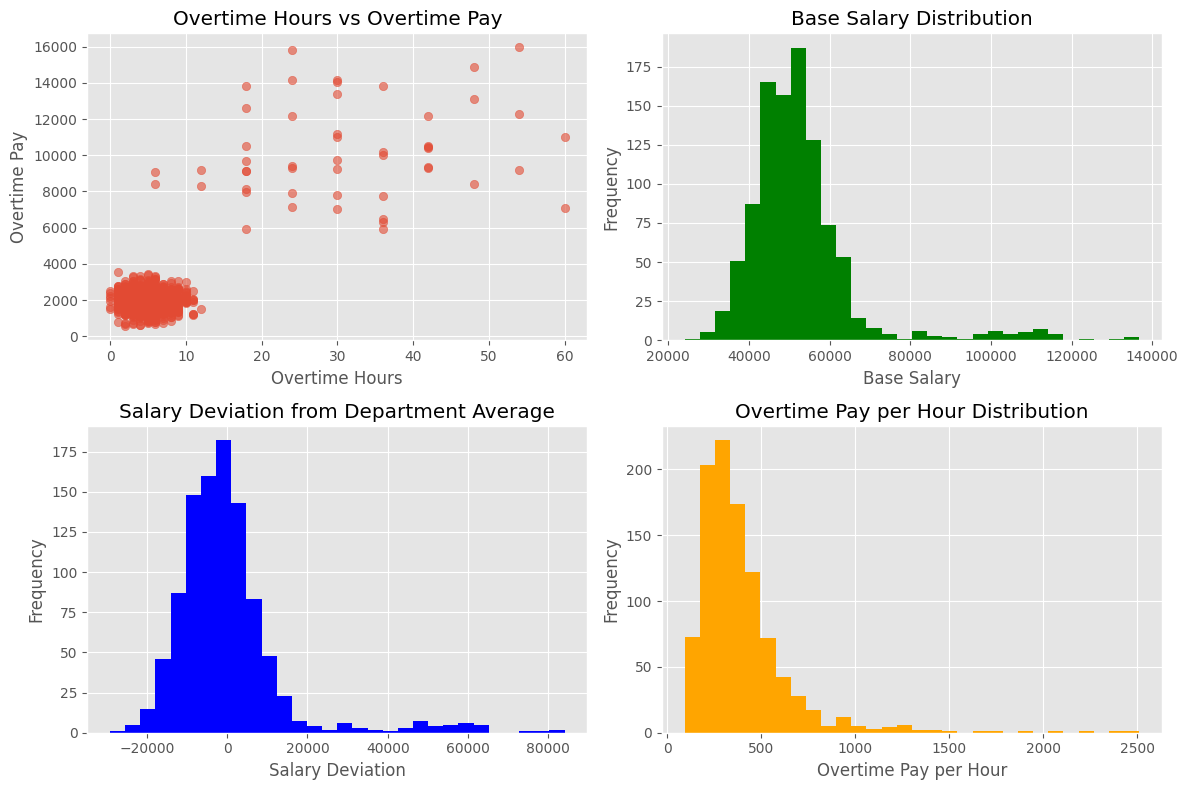

In [105]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# i. Overtime Hours vs Overtime Pay
ax1.scatter(df["overtime_hours"], df["overtime_pay"], alpha=0.6)
ax1.set_xlabel("Overtime Hours")
ax1.set_ylabel("Overtime Pay")
ax1.set_title("Overtime Hours vs Overtime Pay")

# ii. Base Salary Distribution
ax2.hist(df["base_salary"], bins=30, color='green')
ax2.set_xlabel("Base Salary")
ax2.set_ylabel("Frequency")
ax2.set_title("Base Salary Distribution")

# iii. Salary Deviation from Department Average
ax3.hist(df["salary_deviation"], bins=30, color='blue')
ax3.set_xlabel("Salary Deviation")
ax3.set_ylabel("Frequency")
ax3.set_title("Salary Deviation from Department Average")

# iv. Overtime Pay per Hour Distribution
ax4.hist(df["overtime_pay_per_hour"], bins=30, color='orange')
ax4.set_xlabel("Overtime Pay per Hour")
ax4.set_ylabel("Frequency")
ax4.set_title("Overtime Pay per Hour Distribution")

plt.tight_layout()
plt.show()

**->** Insights of **Overtime hours vs Overtime pay**
1. Normal behaviour - Linearly increase
2. Abnormal behaviour (anomalies)
   1. Very high pay for low hours
   2. Extremely high hours with abnormal pay \
These points are strong **fake overtime candidates**

**->** Insights of **Base salary distribution**
1. Normal beahiour - Most salaries should cluster in a normal range
2. Abnormal behaviour (anomalies)
   1. Extreme right tail (very high salaries)
   2. Sudden spikes → possible manipulation

**->** Insights of **Salary Deviation from Departmental Average**
1. Values near 0 - normal employees
2. Abnormal behaviour (anomalies)
   1. Large positive deviations
   2. Indicates salary inflated beyond peers

**->** Insights of **Overtime pay per hour distribution**
1. Normal behaviour - Most values should lie in a narrow band
2. Abnormal behaviour (anomalies)
   1. Very high pay/hour
   2. Suggests manipulated overtime entries

# Step 6 : Feature Selection
**Select relevant features that help identify anomalous payroll behavior.**

In [106]:
features = [
    "base_salary",
    "overtime_hours",
    "overtime_pay",
    "overtime_pay_per_hour",
    "salary_deviation",
    "department_encoded"
]

X = df[features]

# Step 7 : Feature Scaling
**Normalize or standardize features to ensure fair model learning using StandardScalar.**

In [107]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 8 : Model Selection 
**Choose an appropriate unsupervised anomaly detection algorithm**

I choose Isolation forest becuase - 
1. Unsupervised – works without labeled fraud data
2. Suitable for real-world payroll data where anomalies are not pre-tagged
3. Handles high-dimensional features (salary, overtime, department, time, etc.)
4. Assumes anomalies are rare, which matches payroll fraud scenarios
5. Efficient and scalable for batch and real-time detection
6. Easy to interpret anomaly scores for audits and reviews

# Step 9 : Model Training
**Train the model on historical payroll data assuming most records are normal.**

In [108]:
model = IsolationForest(
    n_estimators=200,
    contamination=0.05,  # assume 5% anomalies
    random_state=42
)

model.fit(X_scaled)

,n_estimators,200
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


# Step 10 : Anomaly Scoring
**Generate anomaly scores for each payroll record**

In [109]:
df["anomaly_score"] = model.decision_function(X_scaled)
df["anomaly_flag"] = model.predict(X_scaled)
df

,employee_id,base_salary,overtime_hours,overtime_pay,department,pay_date,overtime_pay_per_hour,department_average_salary,salary_deviation,department_encoded,day,month,weekday,anomaly_score,anomaly_flag
0,1,53974.0,4,2511.0,Finance,2024-01-01,502.200000,52738.184100,1235.815900,0,1,1,0,0.197894,1
1,2,48894.0,7,1905.0,Tech,2024-01-02,238.125000,53263.153226,-4369.153226,3,2,1,1,0.212190,1
2,3,55182.0,7,1713.0,Finance,2024-01-03,214.125000,52738.184100,2443.815900,0,3,1,2,0.199287,1
3,4,62184.0,2,1859.0,Ops,2024-01-04,619.666667,51478.229008,10705.770992,2,4,1,3,0.162095,1
4,5,48127.0,5,2290.0,Finance,2024-01-05,381.666667,52738.184100,-4611.184100,0,5,1,4,0.208093,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,47751.0,8,1888.0,Ops,2026-09-22,209.777778,51478.229008,-3727.229008,2,22,9,1,0.209777,1
996,997,64381.0,1,1478.0,Finance,2026-09-23,739.000000,52738.184100,11642.815900,0,23,9,2,0.090823,1
997,998,55127.0,5,2892.0,Finance,2026-09-24,482.000000,52738.184100,2388.815900,0,24,9,3,0.162930,1
998,999,45431.0,3,2841.0,HR,2026-09-25,710.250000,53321.577689,-7890.577689,1,25,9,4,0.173916,1


# Step 11 : Anomaly Detection / Extract anomalies
**Flag records with high anomaly scores as suspicious and display them.**

In [110]:
anomalies = df[df["anomaly_flag"] == -1]
anomalies.head()

,employee_id,base_salary,overtime_hours,overtime_pay,department,pay_date,overtime_pay_per_hour,department_average_salary,salary_deviation,department_encoded,day,month,weekday,anomaly_score,anomaly_flag
36,37,103342.0,18,10515.0,Finance,2024-02-06,553.421053,52738.184100,50603.815900,0,6,2,1,-0.057847,-1
37,38,68646.0,36,5940.0,Tech,2024-02-07,160.540541,53263.153226,15382.846774,3,7,2,2,-0.045192,-1
55,56,114900.0,48,14855.0,Finance,2024-02-25,303.163265,52738.184100,62161.815900,0,25,2,6,-0.117510,-1
62,63,82298.0,42,9290.0,HR,2024-03-03,216.046512,53321.577689,28976.422311,1,3,3,6,-0.040121,-1
97,98,104176.0,30,13405.0,HR,2024-04-07,432.419355,53321.577689,50854.422311,1,7,4,6,-0.048964,-1


In [111]:
# Filter only anomalous records
anomalies = df[df["anomaly_flag"] == -1]

# Number of anomalies per department
dept_anomalies = anomalies.groupby("department").size()
print("Anomalies per Department:")
print(dept_anomalies)

# Salary anomalies
# Define as anomalies where base_salary is unusually high
# Threshold: salary deviation > 2*std deviation
salary_threshold = 2 * df["salary_deviation"].std()
salary_anomalies = anomalies[anomalies["salary_deviation"] > salary_threshold]
print("Number of Salary Anomalies:", len(salary_anomalies))

# Fake overtime anomalies
# Define as anomalies where overtime_pay_per_hour is unusually high
overtime_threshold = 2 * df["overtime_pay_per_hour"].std()
fake_overtime_anomalies = anomalies[anomalies["overtime_pay_per_hour"] > overtime_threshold]
print("Number of Fake Overtime Anomalies:", len(fake_overtime_anomalies))

Anomalies per Department:
department
Finance    15
HR         17
Ops         7
Tech       11
dtype: int64
Number of Salary Anomalies: 45
Number of Fake Overtime Anomalies: 10


# Step 12 : Evaluation strategy
**Evaluate model behavior using statistical thresholds, stability checks, and manual review.**

Evaluation logic:
1. Anomaly rate should be small & stable
2. Sudden spikes → drift or fraud surge
3. Manual review of top anomalies

In [112]:
# Percentage of anomalies
anomaly_rate = len(anomalies) / len(df)
print("Anomaly Rate:", anomaly_rate)

Anomaly Rate: 0.05


**Anomaly rate** is small and stable

# Step 13 : Concept Drift Handling 
**Monitor data distribution changes and retrain the model periodically.**

**Concept drift occurs when the statistical behavior of data changes over time, causing a trained model to become less accurate.**\
In payroll systems, drift can happen when:
1. Salary structures change (annual hikes)
2. Overtime policies change
3. New departments or roles are added
4. Work patterns shift (remote work, peak seasons)

**Concept drift is handled by detect → monitor → retrain.** \
Core strategies used in this assignment:
1. Statistical distribution monitoring
2. Anomaly monitoring
3. Time-based retraining (batch)
4. Continuous logging (real-time)

Before getting into concept Drift Handling, we need to create new data.

# Step 13.1 : Create old vs new Data

In [113]:
import numpy as np
import pandas as pd

old_data = pd.DataFrame({
    "base_salary": df["base_salary"], 
    "overtime_hours": df["overtime_hours"], 
    "overtime_pay": df["overtime_pay"], 
    "overtime_pay_per_hour": df["overtime_pay_per_hour"], 
    "salary_deviation": df["salary_deviation"], 
    "department_encoded": df["department_encoded"]
})

new_data = pd.DataFrame({
    "base_salary": np.random.normal(80000, 6000, 300),
    "overtime_hours": np.random.normal(12, 3, 300).clip(0),
    "overtime_pay": np.random.normal(12000, 3000, 300),
    "overtime_pay_per_hour": np.random.normal(800, 100, 300),
    "salary_deviation": np.random.normal(10000, 4000, 300),
    "department_encoded": np.random.choice([0, 1, 2, 3], 300)
})


# Step 13.2 : Simple Drift Detection Function

In [114]:
def detect_drift(old, new, threshold=0.2):
    drift_features = []
    
    for col in old.columns:
        old_mean = old[col].mean()
        new_mean = new[col].mean()
        
        change = abs(new_mean - old_mean) / old_mean
        
        if change > threshold:
            drift_features.append(col)
            
    return drift_features

# Step 13.3 : Return drift detection

In [115]:
drifted_features = detect_drift(old_data, new_data)
if drifted_features:
    print("Retraining model due to concept drift...")
    # retrain Isolation Forest using recent data
    model, scaler = retrain_model(new_data)
else:
    print("No drift detected. Continue monitoring.")
    
print("Drift detected in:", drifted_features)

Retraining model due to concept drift...
Drift detected in: ['base_salary', 'overtime_hours', 'overtime_pay', 'overtime_pay_per_hour']


# Step 13.4 : Retraining isolation forest with new data

In [116]:
#Using sliding window retraining

def retrain_model(new_data):
    X_new = new_data[features]
    
    # Refit scaler and model together (batch pipeline only)
    new_scaler = StandardScaler()
    X_new_scaled = new_scaler.fit_transform(X_new)
    
    new_model = IsolationForest(
        contamination=0.05,
        random_state=42
    )
    new_model.fit(X_new_scaled)  
    return new_model, new_scaler

Drift Handling ideas - 
1. Monitor feature distribution
2. Compare anomaly rate month-to-month

# Step 14 : Batch Pipeline (Daily / Monthly)
**Batch Pipeline Design - Run anomaly detection on scheduled payroll batches for audits and compliance.**

Role of Batch Pipeline
1. Works on historical data
2. Ideal for drift detection
3. Low urgency, high accuracy

In [117]:
def batch_detection(data):
    X = scaler.transform(data[features])
    data["anomaly"] = model.predict(X)
    return data[data["anomaly"] == -1]

batch_detection(df)

,employee_id,base_salary,overtime_hours,overtime_pay,department,pay_date,overtime_pay_per_hour,department_average_salary,salary_deviation,department_encoded,day,month,weekday,anomaly_score,anomaly_flag,anomaly
0,1,53974.0,4,2511.0,Finance,2024-01-01,502.200000,52738.184100,1235.815900,0,1,1,0,0.197894,1,-1
1,2,48894.0,7,1905.0,Tech,2024-01-02,238.125000,53263.153226,-4369.153226,3,2,1,1,0.212190,1,-1
2,3,55182.0,7,1713.0,Finance,2024-01-03,214.125000,52738.184100,2443.815900,0,3,1,2,0.199287,1,-1
3,4,62184.0,2,1859.0,Ops,2024-01-04,619.666667,51478.229008,10705.770992,2,4,1,3,0.162095,1,-1
4,5,48127.0,5,2290.0,Finance,2024-01-05,381.666667,52738.184100,-4611.184100,0,5,1,4,0.208093,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,47751.0,8,1888.0,Ops,2026-09-22,209.777778,51478.229008,-3727.229008,2,22,9,1,0.209777,1,-1
996,997,64381.0,1,1478.0,Finance,2026-09-23,739.000000,52738.184100,11642.815900,0,23,9,2,0.090823,1,-1
997,998,55127.0,5,2892.0,Finance,2026-09-24,482.000000,52738.184100,2388.815900,0,24,9,3,0.162930,1,-1
998,999,45431.0,3,2841.0,HR,2026-09-25,710.250000,53321.577689,-7890.577689,1,25,9,4,0.173916,1,-1


Used for:
1. Payroll audits
2. Compliance checks

# Step 15 : Real-Time Pipeline Design 
**Detect anomalies instantly during live payroll or overtime submissions.**

**Role of Real-Time Pipeline**
1. Scores one payroll event at a time
2. Cannot retrain instantly
3. Focuses on monitoring

**Real-Time Drift Signals**
1. Sudden spike in anomaly rate
2. Many alerts from same department
3. Repeated anomalies for normal events

In [118]:
def realtime_detection(single_record):
    record_df = pd.DataFrame([single_record])
    record_df["department_encoded"] = encoder.transform(record_df["department"])
    record_df["overtime_pay_per_hour"] = single_record["overtime_pay"] / (single_record["overtime_hours"] + 1)
    record_df['department_average_salary'] = record_df.groupby("department")['base_salary'].transform('mean')
    record_df['salary_deviation'] = record_df['base_salary'] - record_df['department_average_salary']     
    X = scaler.transform(record_df[features])
    result = model.predict(X)
    
    return "Anomaly" if result[0] == -1 else "Normal"

event1 = {
    "base_salary": 1700000,
    "overtime_hours": 20,
    "overtime_pay": 9000,
    "department": "Tech",
    "event_time": datetime.now()
}

event2 = {
    "base_salary": 70000,
    "overtime_hours":24,
    "overtime_pay":10000,
    "department":"HR",
    "event_time":datetime.now()
} 
print(realtime_detection(event1))
print(realtime_detection(event2))

Anomaly
Anomaly


Used for:
1. Live overtime submission alerts

# Step 16 : Deployment Planning (Basic)
**Deploy the model with monitoring, logging, and alert mechanisms.**

**-> Model Packaging** - Required so predictions stay consistent
1. Save trained Isolation Forest model
2. Save scaler and label encoder
3. Load the same objects in both pipelines

**-> Batch Pipeline Deployment** - Required for audits and model freshness
1. Run on a schedule (daily / monthly)
2. Process full payroll dataset
3. Generate anomaly reports
4. Check for concept drift
5. Retrain model only if drift is detected

**-> Real-Time Pipeline Deployment** - Required to prevent fraud in real time
1. Use deployed model for instant scoring
2. Score each payroll / overtime event
3. Flag anomalies immediately
4. Log predictions

**-> Concept Drift Handling** - Required to keep model accurate over time
1. Compare recent data with historical data
2. Monitor anomaly rate changes
3. Retrain model in batch pipeline when drift appears

**-> Logging & Monitoring** - Required for debugging and validation
1. Log anomaly scores and flags
2. Track anomaly rate over time

To know complete deployment plan & Pesudocode, read DEPLOYMENT_PLAN.md 